In [1]:
import math
import pickle

import igraph as ig
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as sf, types as st
from pyspark import SparkConf
from pyspark.sql import SparkSession

import settings as s

In [2]:
sns.set_theme(style="white", context="talk")

In [3]:
config = [
    ("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.5-s_2.13"),
    ("spark.driver.memory", "8g"),
    ("spark.worker.memory", "8g"),
]
spark = SparkSession.builder.appName("testing").config(conf=SparkConf().setAll(config)).getOrCreate()

:: loading settings :: url = jar:file:/opt/anaconda3/envs/redirect/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/haseeb.tariq/.ivy2/cache
The jars for the packages stored in: /Users/haseeb.tariq/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8a011d89-6a69-486e-ae95-4d7563f9dedc;1.0
	confs: [default]
	found graphframes#graphframes;0.8.3-spark3.5-s_2.13 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 62ms :: artifacts dl 2ms
	:: modules in use:
	graphframes#graphframes;0.8.3-spark3.5-s_2.13 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------------------

In [4]:
PREPARE_INPUT = False

if PREPARE_INPUT:
    %run prepare_input.ipynb

In [5]:
def update_source_target(input_data):
    return input_data.withColumn(
        "source", sf.substring("source", 0, 8)
    ).withColumn(
        "target", sf.substring("target", 0, 8)
    )

In [6]:
%%time

data = update_source_target(spark.read.parquet(s.STAGED_DATA_LOCATION))
data_cases = update_source_target(
    spark.createDataFrame(pd.read_parquet(s.STAGED_CASES_DATA_LOCATION))
)
edges = data.select("source", "target").distinct().toPandas()
graph = ig.Graph.DataFrame(edges, use_vids=False, directed=True)

CPU times: user 24.6 s, sys: 1.02 s, total: 25.7 s
Wall time: 56.7 s


In [7]:
is_ml = sf.col("is_laundering") == 1
ml_sources = data.where(is_ml).select("source").distinct().toPandas()["source"].tolist()
ml_targets = data.where(is_ml).select("target").distinct().toPandas()["target"].tolist()
ml_nodes = set(ml_sources).union(ml_targets)

ml_flow_edges = data_cases.select("source", "target").toPandas().set_index(["source", "target"])
ml_flow_sources = data_cases.select("source").distinct().toPandas()["source"].tolist()
ml_flow_targets = data_cases.select("target").distinct().toPandas()["target"].tolist()
ml_flow_nodes = set(ml_flow_sources).union(ml_flow_targets)

per_overlap = len(ml_flow_nodes.intersection(ml_nodes)) / len(ml_nodes)
print(f"Percentage of ml-flow nodes in ml nodes: {round(per_overlap * 100, 2)}%")

24/06/23 17:53:15 WARN TaskSetManager: Stage 10 contains a task of very large size (1880 KiB). The maximum recommended task size is 1000 KiB.
24/06/23 17:53:17 WARN TaskSetManager: Stage 11 contains a task of very large size (1880 KiB). The maximum recommended task size is 1000 KiB.
24/06/23 17:53:20 WARN TaskSetManager: Stage 14 contains a task of very large size (1880 KiB). The maximum recommended task size is 1000 KiB.


Percentage of ml-flow nodes in ml nodes: 51.74%


In [8]:
flows = data_cases.toPandas()
flows.to_parquet("flows.parquet")

24/06/23 17:53:21 WARN TaskSetManager: Stage 17 contains a task of very large size (1880 KiB). The maximum recommended task size is 1000 KiB.


In [9]:
%%time

flow_stats = []
for flow_type, group in flows.groupby("type"):
    for flow, group_inner in group.groupby("id"):
        flow_data = {"id": flow, "type": flow_type}
        flow_data["sub_type"] = group_inner.iloc[0]["sub_type"]
        group_inner = group_inner.sort_values("timestamp").reset_index(drop=True)
        dates = [x.to_pydatetime().date() for x in group_inner["timestamp"].tolist()]
        dates_shifted = dates[1:] + [dates[-1]]
        flow_data["total_days"] = (max(dates) - min(dates)).days + 1
        day_diffs = [(x - y).days + 1 for x, y in zip(dates_shifted, dates)]
        flow_data["max_days_diff"] = max(day_diffs)
        sources = set(group_inner["source"])
        targets = set(group_inner["target"])
        flow_data["number_sources"] = len(sources)
        flow_data["number_targets"] = len(targets)
        flow_data["number_accounts"] = len(sources.union(targets))
        source_banks = set(group_inner["source_bank"])
        target_banks = set(group_inner["target_bank"])
        flow_data["number_source_banks"] = len(source_banks)
        flow_data["number_target_banks"] = len(target_banks)
        flow_data["number_banks"] = len(source_banks.union(target_banks))
        source_currencies = set(group_inner["source_currency"])
        target_currencies = set(group_inner["target_currency"])
        flow_data["number_source_currencies"] = len(source_currencies)
        flow_data["number_target_currencies"] = len(target_currencies)
        flow_data["number_currencies"] = len(source_currencies.union(target_currencies))
        sub_graph_induced = graph.induced_subgraph(sources.union(targets))
        sub_graph = ig.Graph.DataFrame(group_inner[["source", "target"]], use_vids=False, directed=True)
        distances = np.array(sub_graph.distances(mode="all"))
        max_distance = int(distances[distances < 1e6].max())
        flow_data["max_distance"] = max_distance
        flow_data["max_degree_in"] = max(sub_graph_induced.degree(mode="in"))
        flow_data["max_degree_out"] = max(sub_graph_induced.degree(mode="out"))
        flow_data["max_degree"] = max(sub_graph_induced.degree(mode="all"))
        flow_data["number_components"] = len(sub_graph.connected_components(mode="weak"))
        flow_stats.append(flow_data)
flow_stats = pd.DataFrame(flow_stats)
flow_stats.loc[:, "type"] = flow_stats.loc[:, "type"].str.lower()
flow_stats.loc[:, "sub_type"] = flow_stats.loc[:, "sub_type"].str.lower()
flow_stats.to_parquet("flow_stats.parquet")

CPU times: user 18.3 s, sys: 141 ms, total: 18.4 s
Wall time: 18.4 s


In [10]:
flows_connected = flow_stats.loc[flow_stats["number_components"] == 1, :].reset_index(drop=True)
flows_disconnected = flow_stats.loc[flow_stats["number_components"] > 1, :].reset_index(drop=True)

In [11]:
print(f"Connected flows: {round((flows_connected.shape[0] / flow_stats.shape[0]) * 100, 2)}%")

Connected flows: 83.19%


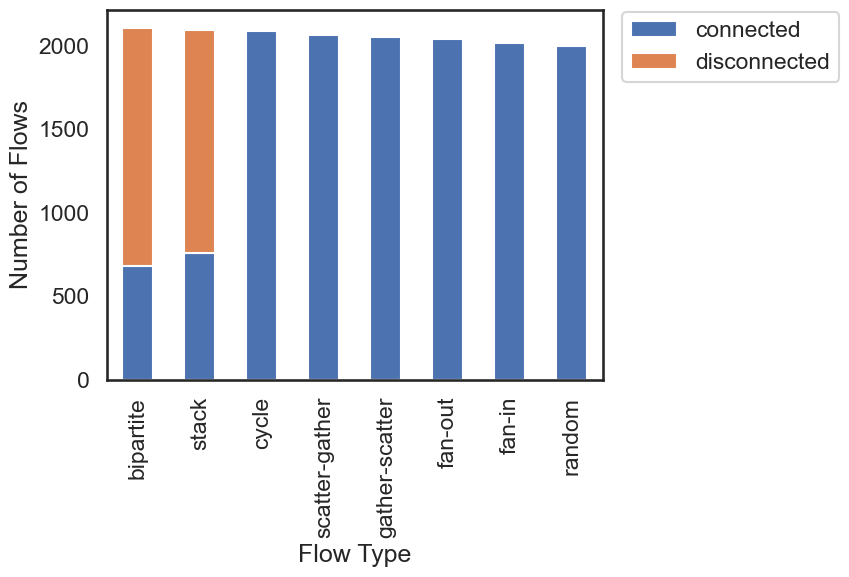

In [12]:
connected_counts = pd.DataFrame(
    flows_connected.groupby("type")["number_components"].count().sort_values()
).rename(columns={"number_components": "connected"})
disconnected_counts = pd.DataFrame(
    flows_disconnected.groupby("type")["number_components"].count().sort_values()
).rename(columns={"number_components": "disconnected"})
connected_vs_disconnected = connected_counts.join(disconnected_counts).fillna(0)
connected_vs_disconnected.loc[:, "x"] = (
    connected_vs_disconnected["connected"] + connected_vs_disconnected["disconnected"]
)
connected_vs_disconnected = connected_vs_disconnected.sort_values("x", ascending=False)
del connected_vs_disconnected["x"]

connected_vs_disconnected.plot(kind="bar", stacked=True)
plt.gca().set_xlabel("Flow Type")
plt.gca().set_ylabel("Number of Flows")
plt.legend(loc="right", bbox_to_anchor=(1.5, 0.9))

Text(0, 0.5, 'Max Number of Days')

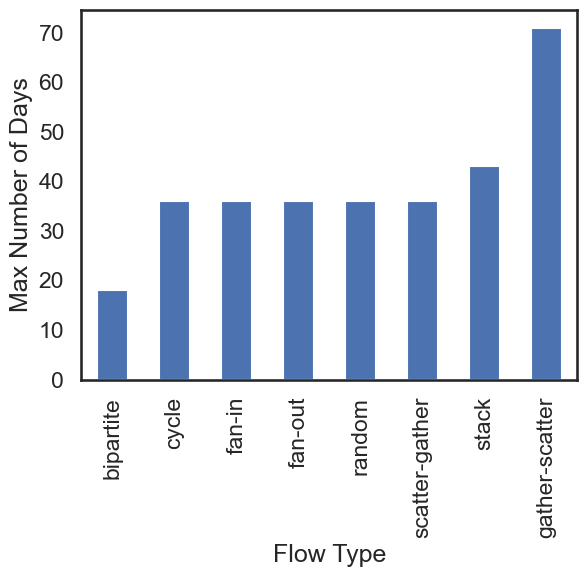

In [13]:
pd.DataFrame(
    flow_stats.groupby("type")["total_days"].max()
).sort_values("total_days").plot(
    kind="bar", stacked=False, legend=None
)
plt.gca().set_xlabel("Flow Type")
plt.gca().set_ylabel("Max Number of Days")

Text(0, 0.5, 'Max Number of Accounts')

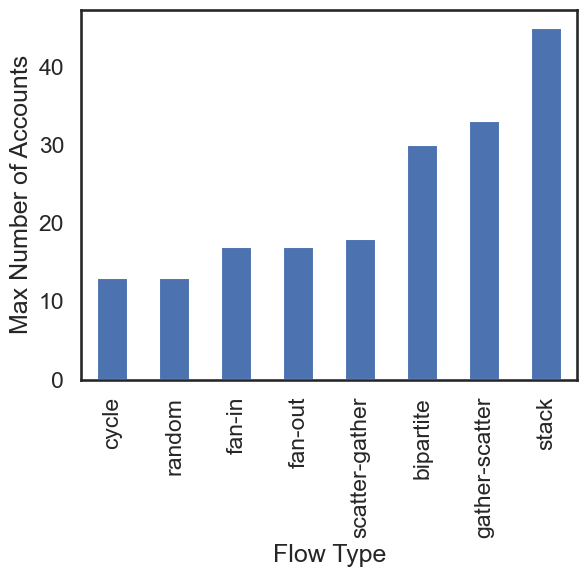

In [14]:
pd.DataFrame(
    flow_stats.groupby("type")["number_accounts"].max()
).sort_values("number_accounts").plot(
    kind="bar", stacked=False, legend=None
)
plt.gca().set_xlabel("Flow Type")
plt.gca().set_ylabel("Max Number of Accounts")

Text(0, 0.5, 'Average Number of Banks')

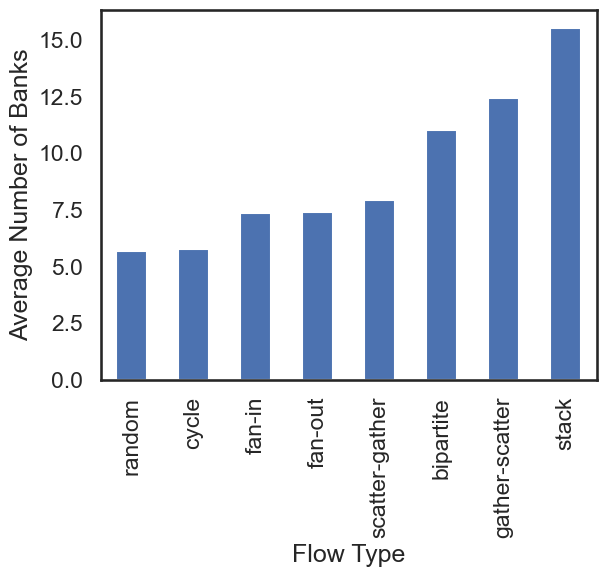

In [15]:
pd.DataFrame(
    flow_stats.groupby("type")["number_banks"].mean()
).sort_values("number_banks").plot(
    kind="bar", stacked=False, legend=None
)
plt.gca().set_xlabel("Flow Type")
plt.gca().set_ylabel("Average Number of Banks")

Text(0, 0.5, 'Maximum Distance')

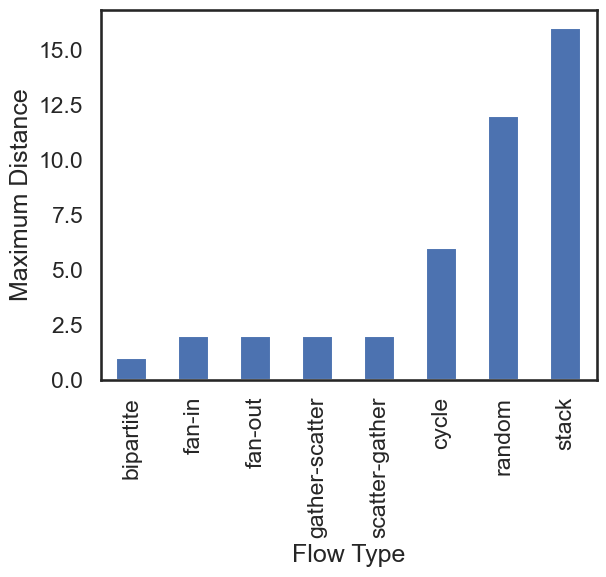

In [16]:
pd.DataFrame(
    flow_stats.groupby("type")["max_distance"].max()
).sort_values("max_distance").plot(
    kind="bar", stacked=False, legend=None
)
plt.gca().set_xlabel("Flow Type")
plt.gca().set_ylabel("Maximum Distance")

Text(0, 0.5, 'Minimum Degree')

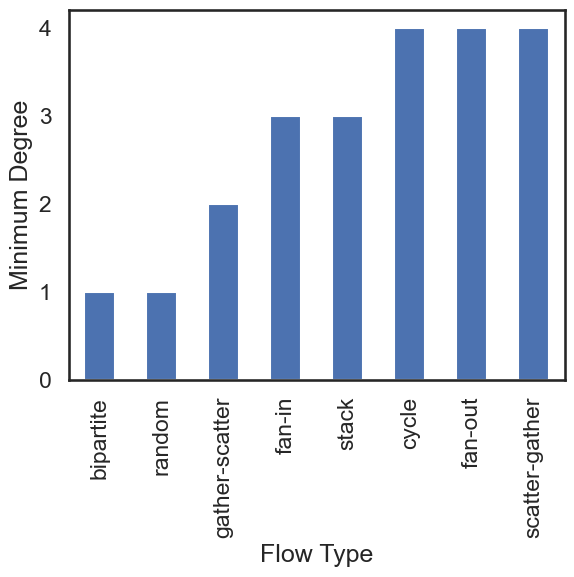

In [17]:
pd.DataFrame(
    flow_stats.groupby("type")["max_degree"].min()
).sort_values("max_degree").plot(
    kind="bar", stacked=False, legend=None
)
plt.gca().set_xlabel("Flow Type")
plt.gca().set_ylabel("Minimum Degree")